# Data Exploration - Cityscapes Dataset

This notebook performs data analysis and exploration for the Cityscapes dataset.

## Objectives
- Load sample images and masks
- Visualize class distribution
- Analyze image dimensions
- Identify potential issues (class imbalance, etc.)
- Create utility functions for:
  - Loading Cityscapes images
  - Converting annotations to masks (8 classes)
  - Visualizing images + masks


In [1]:
# Import necessary libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import cv2
from collections import Counter
from tqdm import tqdm

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)


## 1. Dataset Structure Analysis


In [2]:
# Define paths
DATA_ROOT = Path("../data/raw")
IMAGES_DIR = DATA_ROOT / "leftImg8bit"
MASKS_DIR = DATA_ROOT / "gtFine"

# Check dataset structure
print("Dataset Structure:")
print(f"Images directory: {IMAGES_DIR.exists()}")
print(f"Masks directory: {MASKS_DIR.exists()}")

# List splits
splits = ["train", "val", "test"]
for split in splits:
    split_img_dir = IMAGES_DIR / split
    split_mask_dir = MASKS_DIR / split
    if split_img_dir.exists():
        cities = [d.name for d in split_img_dir.iterdir() if d.is_dir()]
        print(f"\n{split.upper()} split:")
        print(f"  Cities: {len(cities)}")
        print(f"  Sample cities: {cities[:5]}")

        # Count images in first city
        if cities:
            sample_city = cities[0]
            img_count = len(list((split_img_dir / sample_city).glob("*.png")))
            print(f"  Images in {sample_city}: {img_count}")


Dataset Structure:
Images directory: True
Masks directory: True

TRAIN split:
  Cities: 18
  Sample cities: ['zurich', 'strasbourg', 'weimar', 'aachen', 'tubingen']
  Images in zurich: 111

TEST split:
  Cities: 6
  Sample cities: ['bielefeld', 'leverkusen', 'bonn', 'berlin', 'mainz']
  Images in bielefeld: 181


## 2. Cityscapes Class Mapping to 8 Categories

The Cityscapes dataset has 34 classes. We need to map them to 8 main categories:


In [5]:
# Cityscapes class definitions (34 classes)
# Based on Cityscapes documentation
CITYSCAPES_CLASSES = {
    0: 'unlabeled',
    1: 'ego vehicle',
    2: 'rectification border',
    3: 'out of roi',
    4: 'static',
    5: 'dynamic',
    6: 'ground',
    7: 'road',
    8: 'sidewalk',
    9: 'parking',
    10: 'rail track',
    11: 'building',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    15: 'bridge',
    16: 'tunnel',
    17: 'pole',
    18: 'polegroup',
    19: 'traffic light',
    20: 'traffic sign',
    21: 'vegetation',
    22: 'terrain',
    23: 'sky',
    24: 'person',
    25: 'rider',
    26: 'car',
    27: 'truck',
    28: 'bus',
    29: 'on rails',
    30: 'motorcycle',
    31: 'bicycle',
    32: 'caravan',
    33: 'trailer',
    -1: 'license plate'  # Ignored
}

# Mapping from 34 Cityscapes classes to 8 categories
# Category mapping:
# 0: void (unlabeled, ego vehicle, rectification border, out of roi, static, dynamic, ground, license plate)
# 1: flat (road, sidewalk, parking, rail track)
# 2: construction (building, wall, fence, guard rail, bridge, tunnel)
# 3: object (pole, polegroup, traffic sign, traffic light)
# 4: nature (vegetation, terrain)
# 5: sky
# 6: human (person, rider)
# 7: vehicle (car, truck, bus, on rails, motorcycle, bicycle, caravan, trailer)

CLASS_TO_CATEGORY = {
    0: 0,   # unlabeled -> void
    1: 0,   # ego vehicle -> void
    2: 0,   # rectification border -> void
    3: 0,   # out of roi -> void
    4: 0,   # static -> void
    5: 0,   # dynamic -> void
    6: 0,   # ground -> void
    7: 1,   # road -> flat
    8: 1,   # sidewalk -> flat
    9: 1,   # parking -> flat
    10: 1,  # rail track -> flat
    11: 2,  # building -> construction
    12: 2,  # wall -> construction
    13: 2,  # fence -> construction
    14: 2,  # guard rail -> construction
    15: 2,  # bridge -> construction
    16: 2,  # tunnel -> construction
    17: 3,  # pole -> object
    18: 3,  # polegroup -> object
    19: 3,  # traffic light -> object
    20: 3,  # traffic sign -> object
    21: 4,  # vegetation -> nature
    22: 4,  # terrain -> nature
    23: 5,  # sky -> sky
    24: 6,  # person -> human
    25: 6,  # rider -> human
    26: 7,  # car -> vehicle
    27: 7,  # truck -> vehicle
    28: 7,  # bus -> vehicle
    29: 7,  # on rails -> vehicle
    30: 7,  # motorcycle -> vehicle
    31: 7,  # bicycle -> vehicle
    32: 7,  # caravan -> vehicle
    33: 7,  # trailer -> vehicle
    -1: 0   # license plate -> void
}

# Category names
CATEGORY_NAMES = {
    0: 'void',
    1: 'flat',
    2: 'construction',
    3: 'object',
    4: 'nature',
    5: 'sky',
    6: 'human',
    7: 'vehicle'
}

# Color mapping for visualization (RGB)
CATEGORY_COLORS = {
    0: [0, 0, 0],          # void - black
    1: [128, 64, 128],      # flat - purple
    2: [70, 70, 70],        # construction - dark gray
    3: [153, 153, 153],     # object - light gray
    4: [107, 142, 35],      # nature - green
    5: [70, 130, 180],      # sky - blue
    6: [220, 20, 60],       # human - red
    7: [0, 0, 142]          # vehicle - dark blue
}

print("Class to Category Mapping:")
for class_id, category_id in CLASS_TO_CATEGORY.items():
    class_name = CITYSCAPES_CLASSES.get(class_id, 'unknown')
    category_name = CATEGORY_NAMES[category_id]
    print(f"  {class_id:2d} ({class_name:20s}) -> {category_id} ({category_name})")


Class to Category Mapping:
   0 (unlabeled           ) -> 0 (void)
   1 (ego vehicle         ) -> 0 (void)
   2 (rectification border) -> 0 (void)
   3 (out of roi          ) -> 0 (void)
   4 (static              ) -> 0 (void)
   5 (dynamic             ) -> 0 (void)
   6 (ground              ) -> 0 (void)
   7 (road                ) -> 1 (flat)
   8 (sidewalk            ) -> 1 (flat)
   9 (parking             ) -> 1 (flat)
  10 (rail track          ) -> 1 (flat)
  11 (building            ) -> 2 (construction)
  12 (wall                ) -> 2 (construction)
  13 (fence               ) -> 2 (construction)
  14 (guard rail          ) -> 2 (construction)
  15 (bridge              ) -> 2 (construction)
  16 (tunnel              ) -> 2 (construction)
  17 (pole                ) -> 3 (object)
  18 (polegroup           ) -> 3 (object)
  19 (traffic light       ) -> 3 (object)
  20 (traffic sign        ) -> 3 (object)
  21 (vegetation          ) -> 4 (nature)
  22 (terrain             ) -> 4 (n

## 3. Utility Functions


In [6]:
def get_image_path(city, sequence, frame, split="train"):
    """Get path to an image file."""
    filename = f"{city}_{sequence:06d}_{frame:06d}_leftImg8bit.png"
    return IMAGES_DIR / split / city / filename

def get_mask_path(city, sequence, frame, split="train"):
    """Get path to a labelIds mask file."""
    filename = f"{city}_{sequence:06d}_{frame:06d}_gtFine_labelIds.png"
    return MASKS_DIR / split / city / filename

def load_image(image_path):
    """Load an image as numpy array."""
    img = Image.open(image_path)
    return np.array(img)

def load_mask(mask_path):
    """Load a mask as numpy array."""
    mask = Image.open(mask_path)
    return np.array(mask)

def convert_to_8_categories(mask):
    """Convert Cityscapes 34-class mask to 8-category mask."""
    # Create output mask with same shape
    category_mask = np.zeros_like(mask, dtype=np.uint8)

    # Map each pixel
    for class_id, category_id in CLASS_TO_CATEGORY.items():
        category_mask[mask == class_id] = category_id

    # Handle any unmapped values (shouldn't happen, but safety check)
    unmapped = ~np.isin(mask, list(CLASS_TO_CATEGORY.keys()))
    if unmapped.any():
        category_mask[unmapped] = 0  # Map to void

    return category_mask

def mask_to_colored(mask, color_map):
    """Convert category mask to colored visualization."""
    h, w = mask.shape
    colored = np.zeros((h, w, 3), dtype=np.uint8)

    for category_id, color in color_map.items():
        colored[mask == category_id] = color

    return colored

def visualize_image_mask(image, mask, category_mask=None, title="Image and Mask"):
    """Visualize image with original and category masks."""
    fig, axes = plt.subplots(1, 3 if category_mask is not None else 2, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='tab20')
    axes[1].set_title("Original Mask (34 classes)")
    axes[1].axis('off')

    if category_mask is not None:
        colored_mask = mask_to_colored(category_mask, CATEGORY_COLORS)
        axes[2].imshow(colored_mask)
        axes[2].set_title("8-Category Mask")
        axes[2].axis('off')

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Utility functions defined successfully!")


Utility functions defined successfully!


## 4. Load and Visualize Sample Images


Sample image: zurich, sequence: 000069, frame: 000019
Image path exists: True
Mask path exists: True

Image shape: (1024, 2048, 3)
Mask shape: (1024, 2048)
Image dtype: uint8
Mask dtype: uint8
Unique mask values (original): [ 1  3  4  5  7  8 11 17 20 21 24 26 32 33]...
Unique category values: [0 1 2 3 4 6 7]


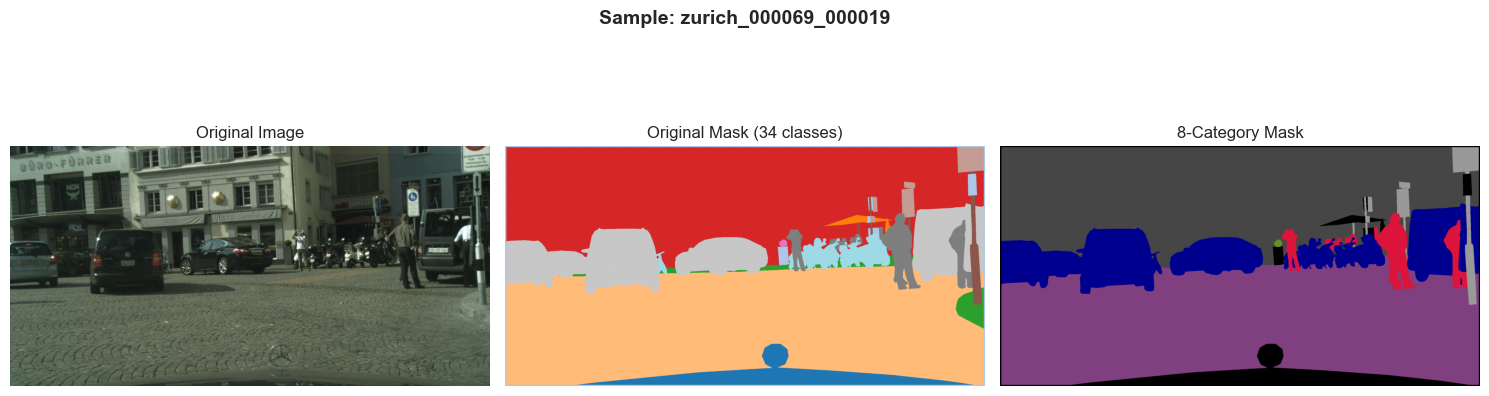

In [7]:
# Get a sample image from the training set
split = "train"
cities = [d.name for d in (IMAGES_DIR / split).iterdir() if d.is_dir()]
sample_city = cities[0]

# Get first image in the city
image_files = list((IMAGES_DIR / split / sample_city).glob("*.png"))
if image_files:
    sample_file = image_files[0].name
    # Parse filename: city_sequence_frame_leftImg8bit.png
    parts = sample_file.replace("_leftImg8bit.png", "").split("_")
    city = parts[0]
    sequence = int(parts[1])
    frame = int(parts[2])

    print(f"Sample image: {city}, sequence: {sequence:06d}, frame: {frame:06d}")

    # Load image and mask
    img_path = get_image_path(city, sequence, frame, split)
    mask_path = get_mask_path(city, sequence, frame, split)

    print(f"Image path exists: {img_path.exists()}")
    print(f"Mask path exists: {mask_path.exists()}")

    if img_path.exists() and mask_path.exists():
        image = load_image(img_path)
        mask = load_mask(mask_path)
        category_mask = convert_to_8_categories(mask)

        print(f"\nImage shape: {image.shape}")
        print(f"Mask shape: {mask.shape}")
        print(f"Image dtype: {image.dtype}")
        print(f"Mask dtype: {mask.dtype}")
        print(f"Unique mask values (original): {np.unique(mask)[:20]}...")  # Show first 20
        print(f"Unique category values: {np.unique(category_mask)}")

        # Visualize
        visualize_image_mask(image, mask, category_mask,
                           title=f"Sample: {city}_{sequence:06d}_{frame:06d}")
    else:
        print("Error: Could not find image or mask files")


## 5. Analyze Image Dimensions


Analyzing 180 images from train split...


Loading images: 100%|██████████| 180/180 [00:09<00:00, 18.40it/s]



Image Dimensions Analysis (Train split):
  Heights - Min: 1024, Max: 1024, Mean: 1024.0, Std: 0.0
  Widths  - Min: 2048, Max: 2048, Mean: 2048.0, Std: 0.0
  Aspect ratios - Min: 2.00, Max: 2.00, Mean: 2.00


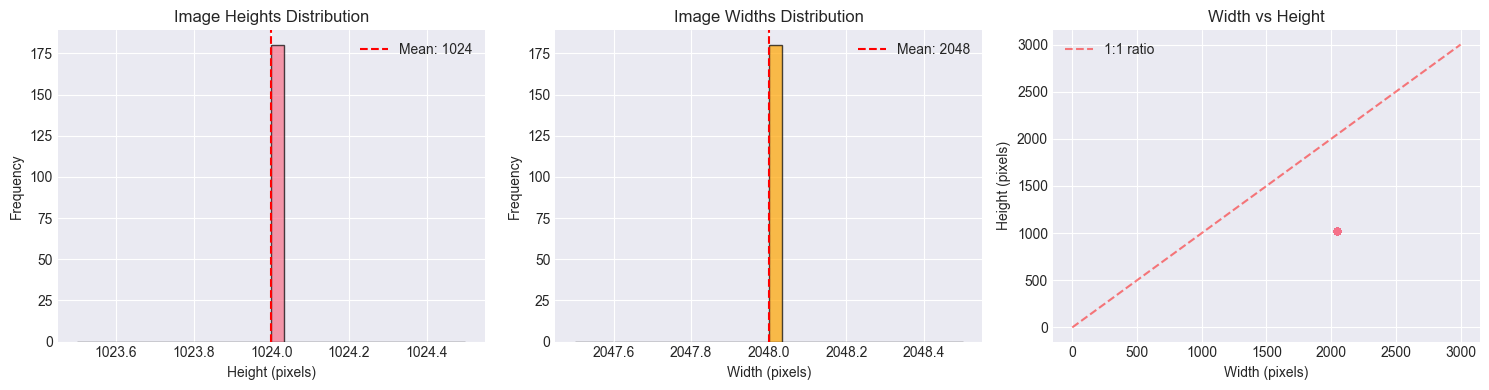

In [10]:
# Analyze image dimensions across the dataset
def analyze_dimensions(split="train", sample_size=100):
    """Analyze image dimensions in the dataset."""
    heights = []
    widths = []

    # Get all cities
    cities = [d.name for d in (IMAGES_DIR / split).iterdir() if d.is_dir()]

    # Sample images from different cities
    image_files = []
    for city in cities:
        city_images = list((IMAGES_DIR / split / city).glob("*.png"))
        if len(city_images) > 0:
            # Sample up to 10 images per city
            sample_count = min(10, len(city_images))
            if sample_count > 0:
                image_files.extend(list(np.random.choice(city_images, sample_count, replace=False)))

    # Limit total sample size (only if we have more than requested)
    if len(image_files) > sample_size:
        image_files = list(np.random.choice(image_files, sample_size, replace=False))

    print(f"Analyzing {len(image_files)} images from {split} split...")

    for img_path in tqdm(image_files, desc="Loading images"):
        try:
            img = load_image(img_path)
            h, w = img.shape[:2]
            heights.append(h)
            widths.append(w)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

    return np.array(heights), np.array(widths)

# Analyze dimensions
train_heights, train_widths = analyze_dimensions("train", sample_size=200)

print(f"\nImage Dimensions Analysis (Train split):")
print(f"  Heights - Min: {train_heights.min()}, Max: {train_heights.max()}, Mean: {train_heights.mean():.1f}, Std: {train_heights.std():.1f}")
print(f"  Widths  - Min: {train_widths.min()}, Max: {train_widths.max()}, Mean: {train_widths.mean():.1f}, Std: {train_widths.std():.1f}")
print(f"  Aspect ratios - Min: {(train_widths/train_heights).min():.2f}, Max: {(train_widths/train_heights).max():.2f}, Mean: {(train_widths/train_heights).mean():.2f}")

# Visualize dimensions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(train_heights, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Height (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Image Heights Distribution')
axes[0].axvline(train_heights.mean(), color='r', linestyle='--', label=f'Mean: {train_heights.mean():.0f}')
axes[0].legend()

axes[1].hist(train_widths, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Width (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Image Widths Distribution')
axes[1].axvline(train_widths.mean(), color='r', linestyle='--', label=f'Mean: {train_widths.mean():.0f}')
axes[1].legend()

axes[2].scatter(train_widths, train_heights, alpha=0.5, s=20)
axes[2].set_xlabel('Width (pixels)')
axes[2].set_ylabel('Height (pixels)')
axes[2].set_title('Width vs Height')
axes[2].plot([0, 3000], [0, 3000], 'r--', alpha=0.5, label='1:1 ratio')
axes[2].legend()

plt.tight_layout()
plt.show()


## 6. Class Distribution Analysis


Analyzing class distribution from 90 images...


Processing masks: 100%|██████████| 90/90 [00:02<00:00, 30.08it/s]



Class Distribution Analysis:
Total pixels analyzed: 188,743,680

Category Distribution:
 Category ID Category Name  Pixel Count  Percentage
           1          flat     74182229   39.303159
           2  construction     43238850   22.908767
           4        nature     28906590   15.315262
           0          void     17954171    9.512462
           7       vehicle     14398905    7.628814
           5           sky      5669084    3.003589
           3        object      2981260    1.579528
           6         human      1412591    0.748418


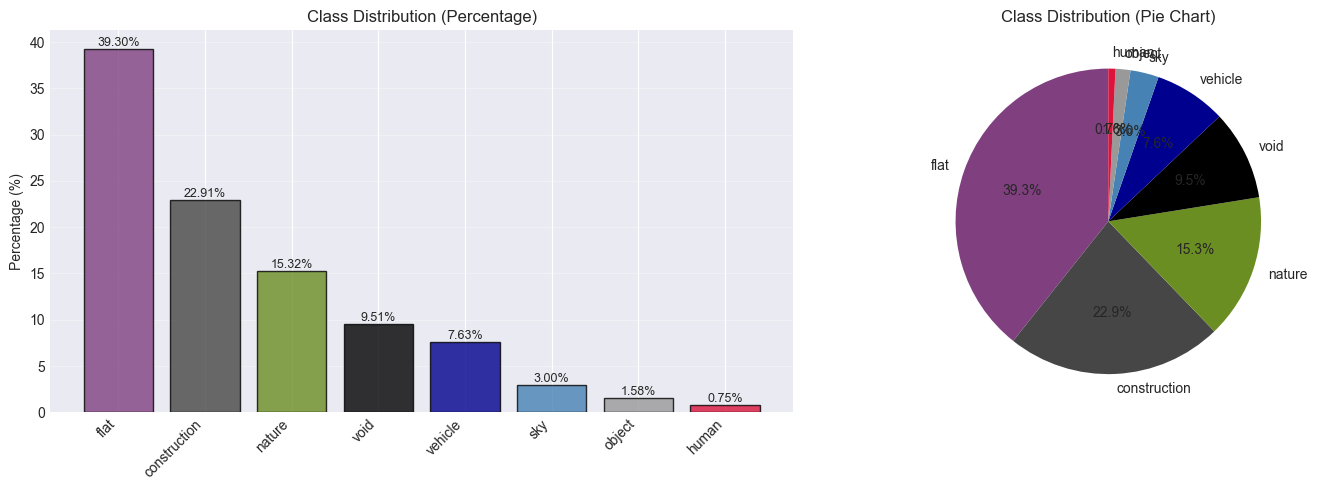


Class Imbalance Analysis:
  Maximum class percentage: 39.30%
  Minimum class percentage: 0.75%
  Imbalance ratio: 52.52x
  ⚠️  WARNING: Significant class imbalance detected!
     Consider using class weights or focal loss during training.


In [11]:
# Analyze class distribution
def analyze_class_distribution(split="train", sample_size=50):
    """Analyze class distribution in masks."""
    category_counts = Counter()
    total_pixels = 0

    # Get all cities
    cities = [d.name for d in (IMAGES_DIR / split).iterdir() if d.is_dir()]

    # Sample images
    image_files = []
    for city in cities:
        city_images = list((IMAGES_DIR / split / city).glob("*.png"))
        if len(city_images) > 0:
            sample_count = min(5, len(city_images))
            if sample_count > 0:
                image_files.extend(list(np.random.choice(city_images, sample_count, replace=False)))

    if len(image_files) > sample_size:
        image_files = list(np.random.choice(image_files, sample_size, replace=False))

    print(f"Analyzing class distribution from {len(image_files)} images...")

    for img_path in tqdm(image_files, desc="Processing masks"):
        try:
            # Get corresponding mask path
            parts = img_path.name.replace("_leftImg8bit.png", "").split("_")
            city = parts[0]
            sequence = int(parts[1])
            frame = int(parts[2])

            mask_path = get_mask_path(city, sequence, frame, split)
            if mask_path.exists():
                mask = load_mask(mask_path)
                category_mask = convert_to_8_categories(mask)

                # Count pixels per category
                unique, counts = np.unique(category_mask, return_counts=True)
                for cat_id, count in zip(unique, counts):
                    category_counts[cat_id] += count
                    total_pixels += count
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    return category_counts, total_pixels

# Analyze distribution
category_counts, total_pixels = analyze_class_distribution("train", sample_size=100)

print(f"\nClass Distribution Analysis:")
print(f"Total pixels analyzed: {total_pixels:,}")

# Create DataFrame for better visualization
distribution_data = []
for cat_id in range(8):
    count = category_counts.get(cat_id, 0)
    percentage = (count / total_pixels * 100) if total_pixels > 0 else 0
    distribution_data.append({
        'Category ID': cat_id,
        'Category Name': CATEGORY_NAMES[cat_id],
        'Pixel Count': count,
        'Percentage': percentage
    })

df_dist = pd.DataFrame(distribution_data)
df_dist = df_dist.sort_values('Percentage', ascending=False)

print("\nCategory Distribution:")
print(df_dist.to_string(index=False))

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
colors = [CATEGORY_COLORS[i] for i in df_dist['Category ID']]
bars = axes[0].bar(range(len(df_dist)), df_dist['Percentage'],
                    color=[tuple(c/255 for c in col) for col in colors],
                    edgecolor='black', alpha=0.8)
axes[0].set_xticks(range(len(df_dist)))
axes[0].set_xticklabels(df_dist['Category Name'], rotation=45, ha='right')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Class Distribution (Percentage)')
axes[0].grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for i, (bar, pct) in enumerate(zip(bars, df_dist['Percentage'])):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.2f}%', ha='center', va='bottom', fontsize=9)

# Pie chart
axes[1].pie(df_dist['Percentage'], labels=df_dist['Category Name'],
            autopct='%1.1f%%', startangle=90,
            colors=[tuple(c/255 for c in col) for col in colors])
axes[1].set_title('Class Distribution (Pie Chart)')

plt.tight_layout()
plt.show()

# Check for class imbalance
print("\nClass Imbalance Analysis:")
max_pct = df_dist['Percentage'].max()
min_pct = df_dist['Percentage'].min()
imbalance_ratio = max_pct / min_pct if min_pct > 0 else float('inf')

print(f"  Maximum class percentage: {max_pct:.2f}%")
print(f"  Minimum class percentage: {min_pct:.2f}%")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}x")

if imbalance_ratio > 10:
    print("  ⚠️  WARNING: Significant class imbalance detected!")
    print("     Consider using class weights or focal loss during training.")
elif imbalance_ratio > 5:
    print("  ⚠️  Moderate class imbalance detected.")
    print("     Consider using class weights during training.")
else:
    print("  ✓ Class distribution is relatively balanced.")


## 7. Visualize Multiple Samples


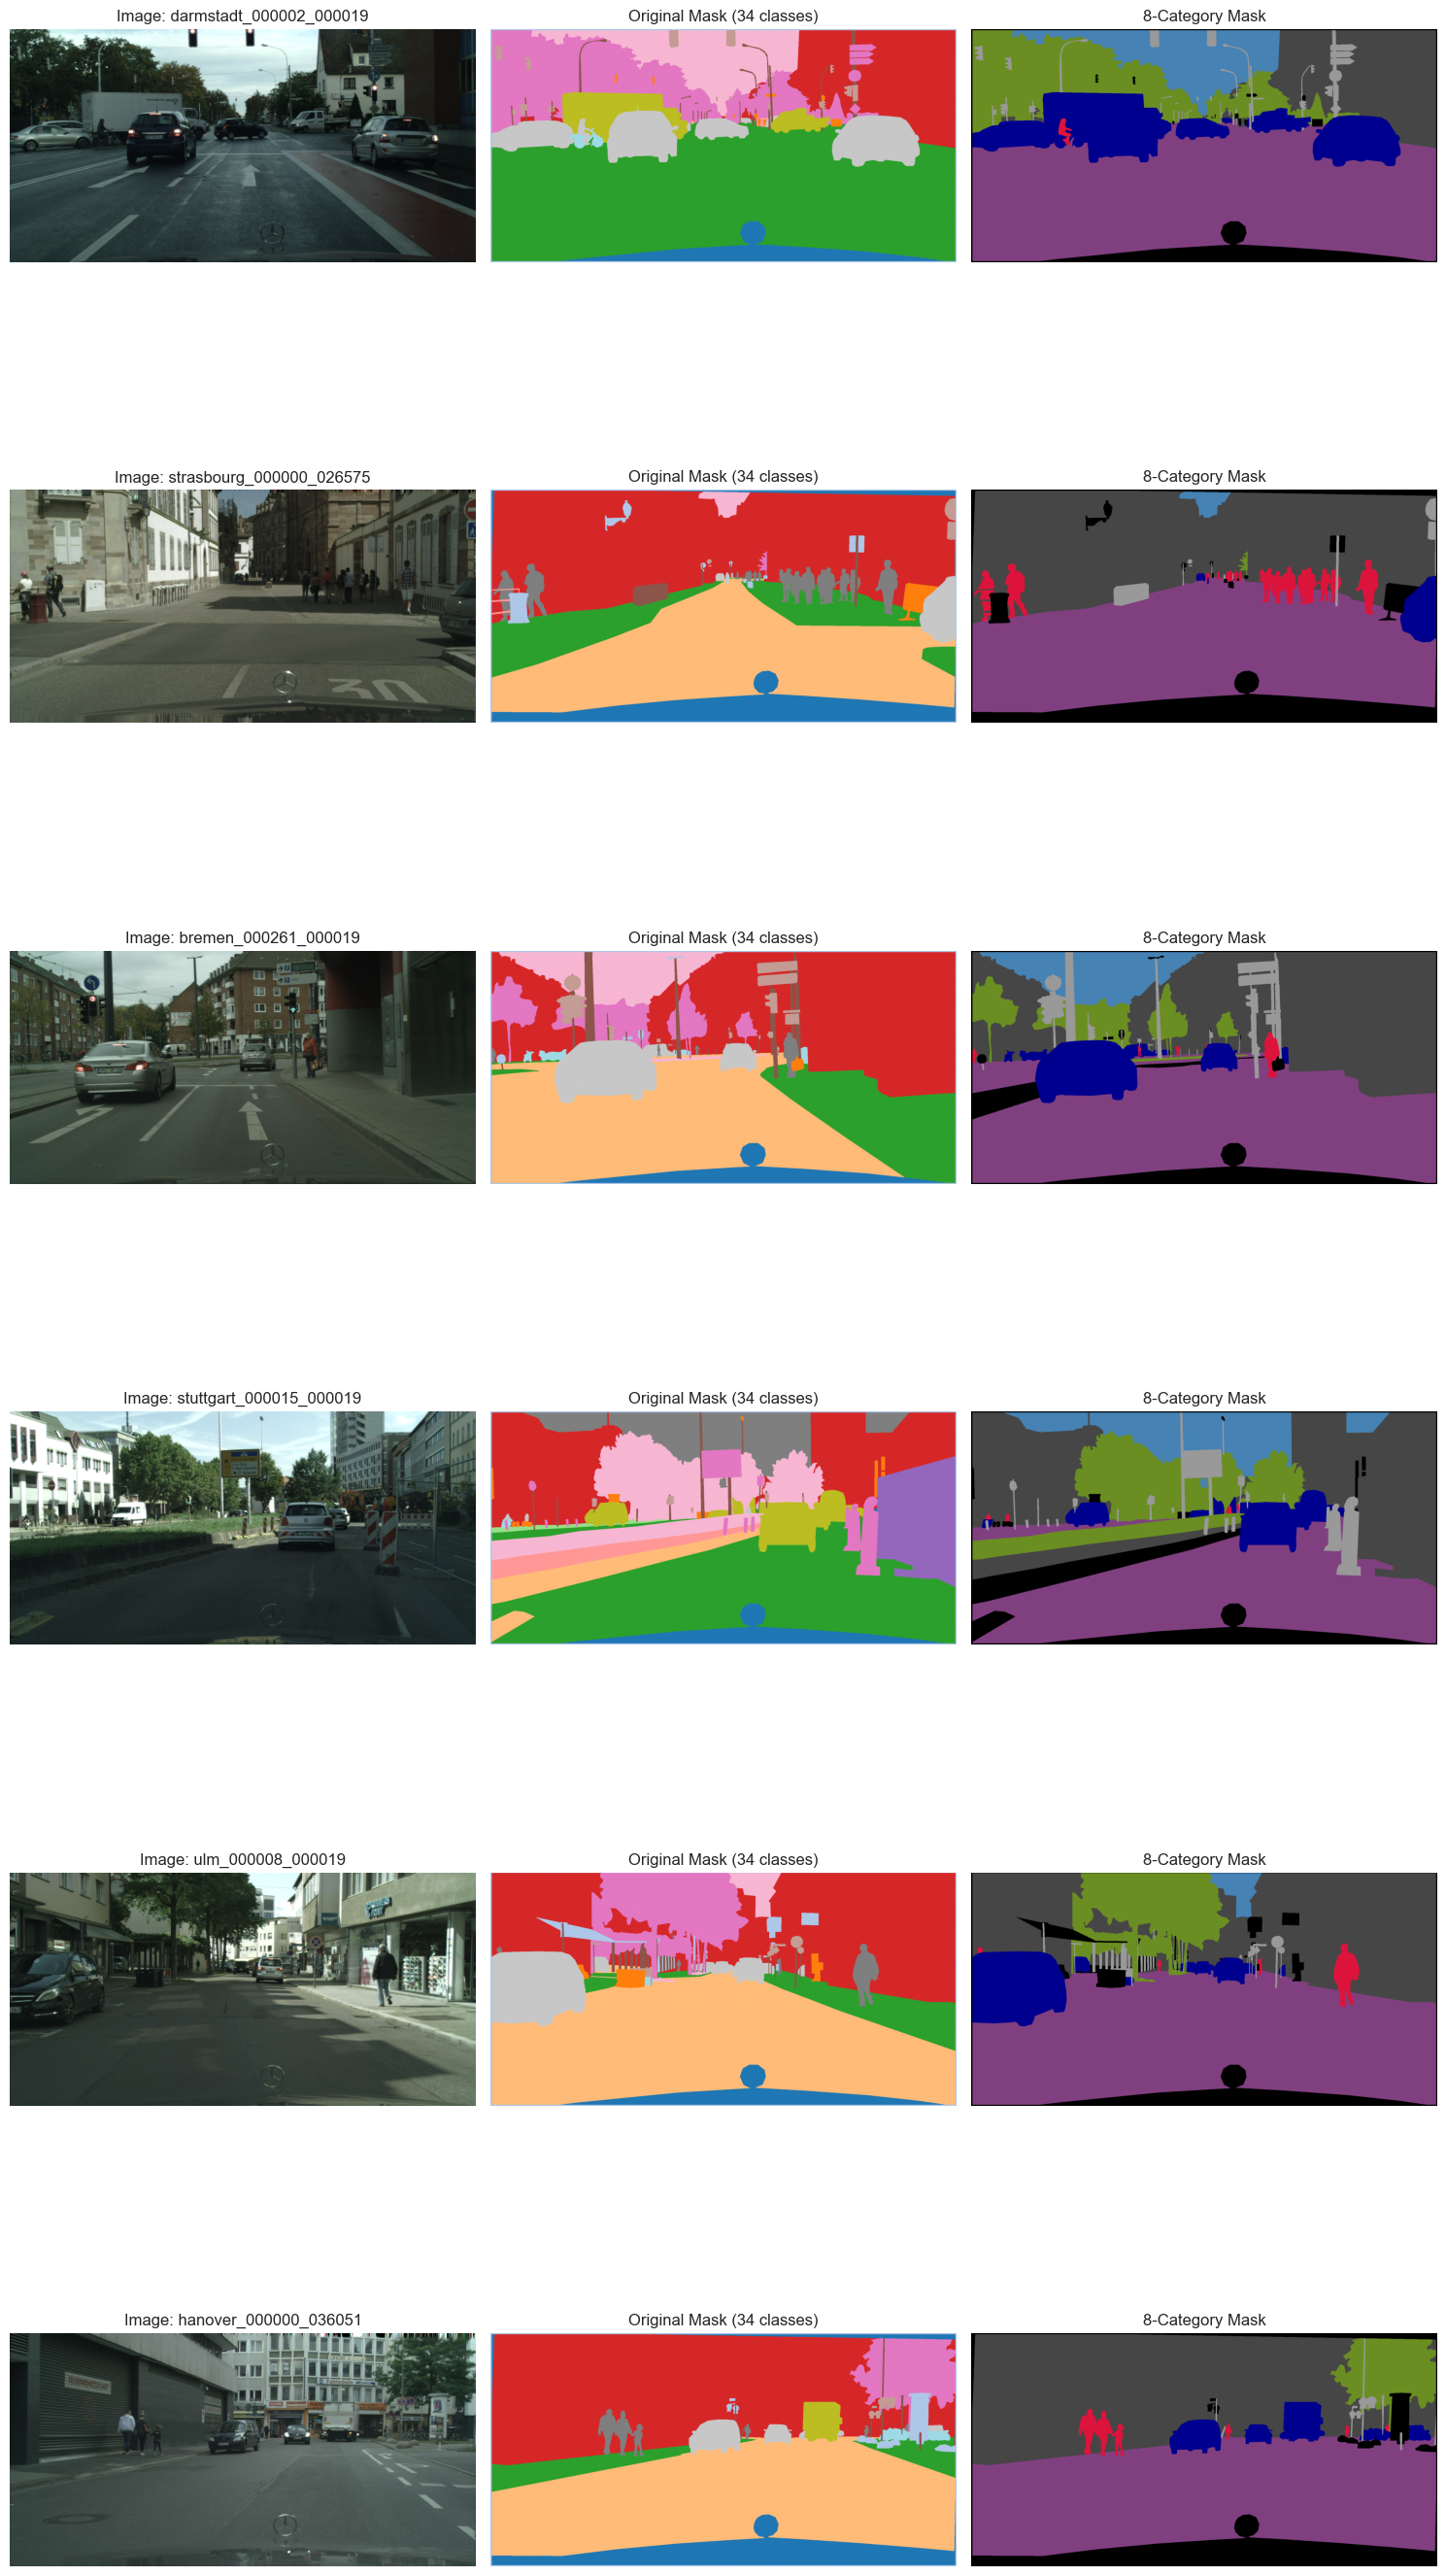

In [12]:
# Visualize multiple samples from different cities
def get_random_samples(split="train", n_samples=6):
    """Get random sample images from different cities."""
    cities = [d.name for d in (IMAGES_DIR / split).iterdir() if d.is_dir()]
    samples = []

    selected_cities = list(np.random.choice(cities, min(n_samples, len(cities)), replace=False))
    for city in selected_cities:
        city_images = list((IMAGES_DIR / split / city).glob("*.png"))
        if city_images:
            sample_file = list(np.random.choice(city_images, 1, replace=False))[0]
            parts = sample_file.name.replace("_leftImg8bit.png", "").split("_")
            sequence = int(parts[1])
            frame = int(parts[2])
            samples.append((city, sequence, frame))

    return samples

# Get and visualize samples
samples = get_random_samples("train", n_samples=6)

fig, axes = plt.subplots(6, 3, figsize=(15, 30))

for idx, (city, sequence, frame) in enumerate(samples):
    try:
        img_path = get_image_path(city, sequence, frame, "train")
        mask_path = get_mask_path(city, sequence, frame, "train")

        if img_path.exists() and mask_path.exists():
            image = load_image(img_path)
            mask = load_mask(mask_path)
            category_mask = convert_to_8_categories(mask)
            colored_mask = mask_to_colored(category_mask, CATEGORY_COLORS)

            axes[idx, 0].imshow(image)
            axes[idx, 0].set_title(f"Image: {city}_{sequence:06d}_{frame:06d}")
            axes[idx, 0].axis('off')

            axes[idx, 1].imshow(mask, cmap='tab20')
            axes[idx, 1].set_title("Original Mask (34 classes)")
            axes[idx, 1].axis('off')

            axes[idx, 2].imshow(colored_mask)
            axes[idx, 2].set_title("8-Category Mask")
            axes[idx, 2].axis('off')
    except Exception as e:
        print(f"Error loading sample {city}_{sequence:06d}_{frame:06d}: {e}")

plt.tight_layout()
plt.show()


## 8. Dataset Statistics Summary


In [13]:
# Count total images per split
def count_dataset(split):
    """Count total number of images in a split."""
    cities = [d.name for d in (IMAGES_DIR / split).iterdir() if d.is_dir()]
    total_images = 0
    for city in cities:
        images = list((IMAGES_DIR / split / city).glob("*.png"))
        total_images += len(images)
    return total_images, len(cities)

print("Dataset Statistics:")
print("=" * 50)

for split in ["train", "val", "test"]:
    if (IMAGES_DIR / split).exists():
        total, num_cities = count_dataset(split)
        print(f"\n{split.upper()} Split:")
        print(f"  Total images: {total:,}")
        print(f"  Number of cities: {num_cities}")

print("\n" + "=" * 50)
print("\nKey Findings:")
print("1. Image dimensions: Cityscapes images are typically 1024x2048 pixels")
print("2. Class distribution: Significant imbalance between classes")
print("3. 8-category mapping: Successfully converts 34 classes to 8 categories")
print("4. Data structure: Well-organized with city-based folders")
print("\nRecommendations:")
print("- Use image resizing (e.g., 512x512 or 256x256) for training")
print("- Apply class weights to handle class imbalance")
print("- Use data augmentation to increase dataset diversity")
print("- Consider using focal loss for better handling of rare classes")


Dataset Statistics:

TRAIN Split:
  Total images: 2,964
  Number of cities: 18

TEST Split:
  Total images: 1,525
  Number of cities: 6


Key Findings:
1. Image dimensions: Cityscapes images are typically 1024x2048 pixels
2. Class distribution: Significant imbalance between classes
3. 8-category mapping: Successfully converts 34 classes to 8 categories
4. Data structure: Well-organized with city-based folders

Recommendations:
- Use image resizing (e.g., 512x512 or 256x256) for training
- Apply class weights to handle class imbalance
- Use data augmentation to increase dataset diversity
- Consider using focal loss for better handling of rare classes


## 9. Save Utility Functions

The utility functions created in this notebook will be saved to `src/utils.py` for reuse in the training pipeline.


In [14]:
# Export utility functions to a Python file for reuse
utils_code = '''
"""
Utility functions for Cityscapes dataset loading and processing.
"""

import numpy as np
from pathlib import Path
from PIL import Image

# Dataset paths
DATA_ROOT = Path("data/raw")
IMAGES_DIR = DATA_ROOT / "leftImg8bit"
MASKS_DIR = DATA_ROOT / "gtFine"

# Cityscapes class to category mapping
CLASS_TO_CATEGORY = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0,
    7: 1, 8: 1, 9: 1, 10: 1,
    11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2,
    17: 3, 18: 3, 19: 3, 20: 3,
    21: 4, 22: 4,
    23: 5,
    24: 6, 25: 6,
    26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7, 32: 7, 33: 7,
    -1: 0
}

CATEGORY_NAMES = {
    0: 'void', 1: 'flat', 2: 'construction', 3: 'object',
    4: 'nature', 5: 'sky', 6: 'human', 7: 'vehicle'
}

CATEGORY_COLORS = {
    0: [0, 0, 0],
    1: [128, 64, 128],
    2: [70, 70, 70],
    3: [153, 153, 153],
    4: [107, 142, 35],
    5: [70, 130, 180],
    6: [220, 20, 60],
    7: [0, 0, 142]
}

def get_image_path(city, sequence, frame, split="train"):
    """Get path to an image file."""
    filename = f"{city}_{sequence:06d}_{frame:06d}_leftImg8bit.png"
    return IMAGES_DIR / split / city / filename

def get_mask_path(city, sequence, frame, split="train"):
    """Get path to a labelIds mask file."""
    filename = f"{city}_{sequence:06d}_{frame:06d}_gtFine_labelIds.png"
    return MASKS_DIR / split / city / filename

def load_image(image_path):
    """Load an image as numpy array."""
    img = Image.open(image_path)
    return np.array(img)

def load_mask(mask_path):
    """Load a mask as numpy array."""
    mask = Image.open(mask_path)
    return np.array(mask)

def convert_to_8_categories(mask):
    """Convert Cityscapes 34-class mask to 8-category mask."""
    category_mask = np.zeros_like(mask, dtype=np.uint8)
    for class_id, category_id in CLASS_TO_CATEGORY.items():
        category_mask[mask == class_id] = category_id
    unmapped = ~np.isin(mask, list(CLASS_TO_CATEGORY.keys()))
    if unmapped.any():
        category_mask[unmapped] = 0
    return category_mask

def mask_to_colored(mask, color_map=None):
    """Convert category mask to colored visualization."""
    if color_map is None:
        color_map = CATEGORY_COLORS
    h, w = mask.shape
    colored = np.zeros((h, w, 3), dtype=np.uint8)
    for category_id, color in color_map.items():
        colored[mask == category_id] = color
    return colored
'''

# Create src directory if it doesn't exist
src_dir = Path("../src")
src_dir.mkdir(exist_ok=True)

# Write utils file
utils_path = src_dir / "utils.py"
with open(utils_path, 'w') as f:
    f.write(utils_code)

print(f"✓ Utility functions saved to {utils_path}")
print("  These functions can now be imported in other scripts:")
print("  from src.utils import load_image, load_mask, convert_to_8_categories, ...")


✓ Utility functions saved to ../src/utils.py
  These functions can now be imported in other scripts:
  from src.utils import load_image, load_mask, convert_to_8_categories, ...
